---
title: "Machine Learning Notes II: KNN"
author: "Alejandro Pérez Sanjuán"
date: 2024-08-09
categories: [machine learning, python, knn]
format: html
---

Personal notes for myself about K-nearest neighbor and how to implement it from scratch.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from functools import partial

from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, r2_score
from scipy.stats import mode

## 1. Introduction

K-Nearest Neighbouts is a supervised learning algorithm that works based on distance metrics. A new point is classified as the $k$ closest neighbours in the space to this new point.

### 1.1. Algorithm

Knn algorithm is probably one of the simplest machine learning models yet it still yields effective results. The idea is to represent the labelled points in the space and classify or regress a new unlabelled point by looking at the labels of the $K$ closests neighbours.

Let's visualize an example. Below, we observe a dataset composed of 10 points. Each point has a label associated. We want to classificy the point in red. Which label do we assign to it?

In [2]:
def plot_knn(k_val=None):
    np.random.seed(3)
    X = np.random.normal(0, 0.05, size=(10, 2))
    y = np.random.choice([0, 1], size=len(X))
    new_point = np.random.normal(0, 0.05, size=2)

    # Compute Euclidean distance from new_point to the rest of the points
    euclidean_from_new_point = partial(euclidean, v=new_point)
    distances = np.apply_along_axis(euclidean_from_new_point, axis=1, arr=X)
    dist_idx_sort = np.argsort(distances)

    # Plot
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    ax.scatter(X[:, 0], X[:, 1], c=y, s=300)
    ax.scatter(new_point[0], new_point[1], c="red", marker="*", s=300)

    if k_val is not None:
        # Sort X based on distance and select the closest k_val points
        closest_points = X[dist_idx_sort][:k_val]
        closest_distances = distances[dist_idx_sort][:k_val]
        
        # Plot arrows to the closest k_val points
        for i in range(closest_points.shape[0]):
            x_target, y_target = closest_points[i]
            distance = closest_distances[i]
            
            # Draw arrow from new_point to the closest point
            ax.annotate(
                '',
                xy=(x_target, y_target),
                xytext=(new_point[0], new_point[1]),
                arrowprops=dict(
                    facecolor='blue',
                    edgecolor='blue',
                    arrowstyle='->',
                    lw=2,
                ),
            )
            
            # Calculate the midpoint for placing the text
            mid_point = (new_point + closest_points[i]) / 2
            ax.text(
                mid_point[0], 
                mid_point[1], 
                f'{distance:.2f}', 
                color='blue',
                fontsize=12,
                ha='center',
                va='center'
            )

    ax.grid(True, alpha=.3)

    if k_val is None:
        ax.set_title("Dataset", fontsize=24)
    else:
        ax.set_title(f"Dataset | k: {k_val}", fontsize=24)
    ax.set_xlabel("Feature $x_{1}$", fontsize=20)
    ax.set_ylabel("Feature $x_{2}$", fontsize=20)
    ax.tick_params(labelsize=20)

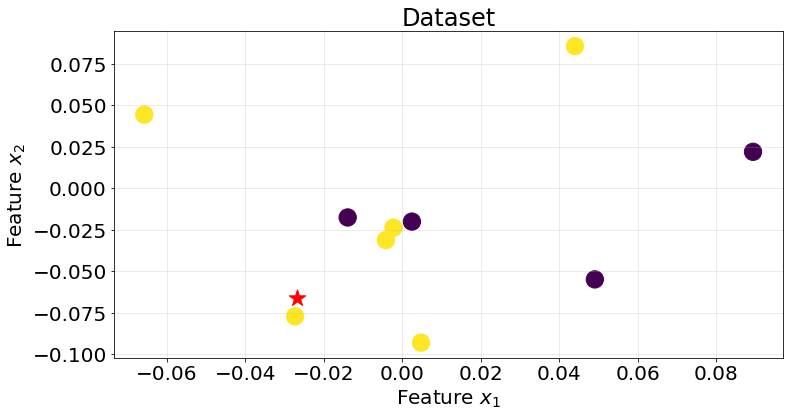

In [3]:
plot_knn()

Knn uses a `distance metric`, like Euclidean distance, to determine the closest neighbours and takes the mode value of its labels to decide which class to assign to the new point. If we were working with continuous values we would assign the average or median value of the labelled datapoints to the new point.

Below I show the plots for the K-nearest neightbours for different values of $K$.

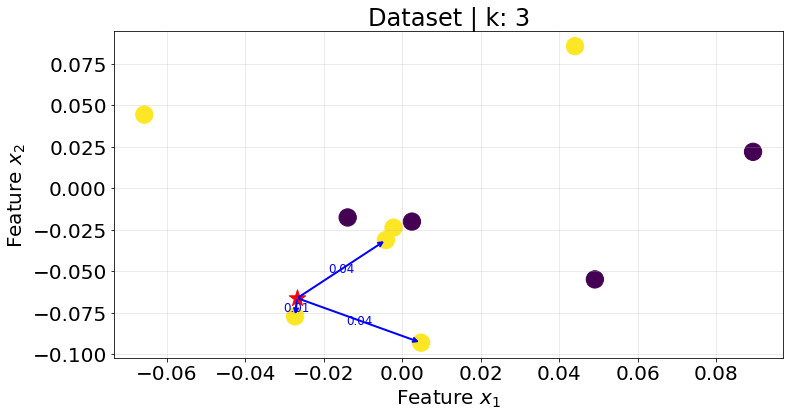

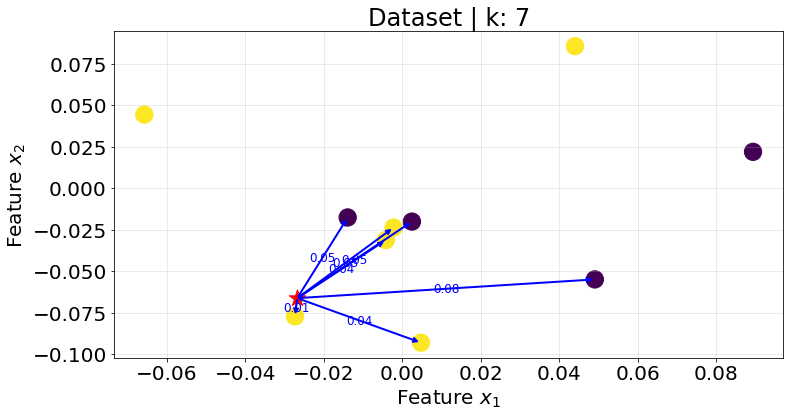

In [4]:
plot_knn(k_val=3)
plot_knn(k_val=7)

Notice that the same point could be assigned to different classes depending on the $K$ value. In addition, it is better to select an odd value for $K$ to avoid ties.

## 2. Coding a Knn from scratch

We code the Knn following Scikit-Learn API for machine learning algorithms. The `distance` metric can be passed as a callable

In [5]:
class KNNModel:
    def __init__(self, is_classification, k_neighbours=3, distance=euclidean):
        self.is_classification = is_classification
        self.k_neighbours = k_neighbours
        self.distance = distance

        # attributes
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        k_neighbours = self.k_neighbours
        is_classification = self.is_classification
        distance = self.distance
        y_train = self.y_train
        X_train = self.X_train

        n_samples = X.shape[0]
        predictions = np.empty(shape=(n_samples, 1))
        for i, x_sample in enumerate(X):
            distance_from_new_point = partial(distance, v=x_sample)
            distances = np.apply_along_axis(
                distance_from_new_point, axis=1, arr=X_train
            )
            dist_idx_sort = np.argsort(distances)

            k_closest_labels = y_train[dist_idx_sort][:k_neighbours]
            if is_classification:
                predictions[i] = mode(k_closest_labels).mode
            else:
                predictions[i] = np.mean(k_closest_labels)

        return predictions

### 2.1. Classification

We test our model using a classification dataset.

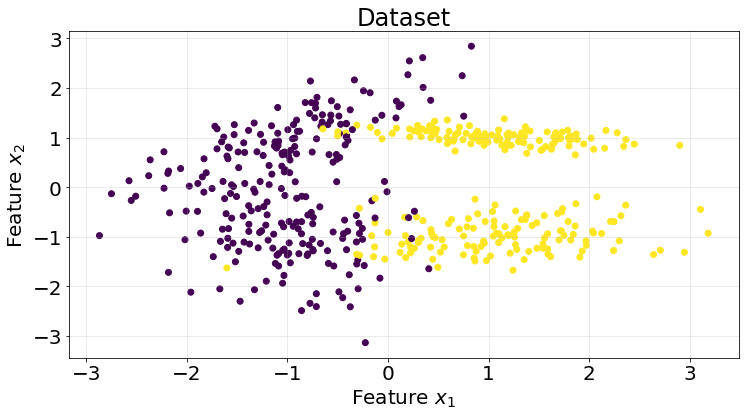

In [6]:
X, y = make_classification(n_samples=500, n_features=2, n_informative=2, n_redundant=0, n_classes=2, random_state=10)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X[:, 0], X[:, 1], c=y)
ax.grid(True, alpha=.3)
ax.set_title("Dataset", fontsize=24)
ax.set_xlabel("Feature $x_{1}$", fontsize=20)
ax.set_ylabel("Feature $x_{2}$", fontsize=20)
ax.tick_params(labelsize=20)

In [7]:
kf = KFold(n_splits=5)

roc_scores = []
for train_idx, test_idx in kf.split(X):
    model = KNNModel(is_classification=True, distance=euclidean)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = roc_auc_score(y_true=y_test, y_score=y_pred)
    roc_scores.append(score)

We find this naive implementation works pretty well for the generated dataset, with an average of 0.95 ROC AUC score within 5 k-fold framework.

In [8]:
np.array(roc_scores).mean()

0.9520628722985057

### 2.2. Regression

What about regression. We perform the same process but using a regression dataset and algorithm

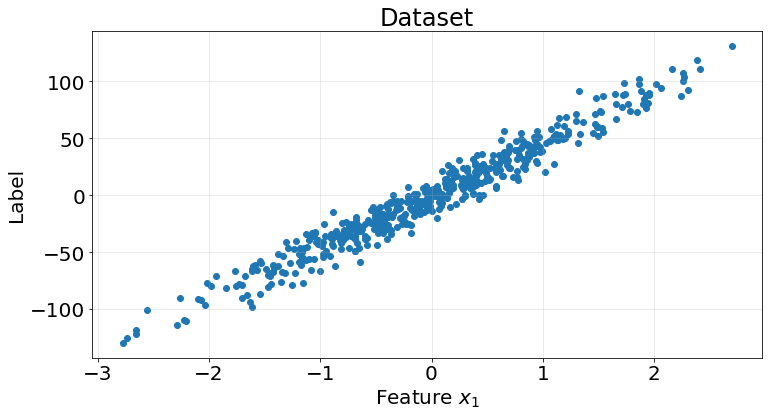

In [9]:
X, y = make_regression(n_samples=500, n_features=1, n_informative=1, n_targets=1, noise=10, random_state=0)

fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.scatter(X, y)
ax.grid(True, alpha=.3)
ax.set_title("Dataset", fontsize=24)
ax.set_xlabel("Feature $x_{1}$", fontsize=20)
ax.set_ylabel("Label", fontsize=20)
ax.tick_params(labelsize=20)

In [10]:
kf = KFold(n_splits=5)

r2_scores = []
for train_idx, test_idx in kf.split(X):
    model = KNNModel(is_classification=False, distance=euclidean)

    X_train = X[train_idx]
    y_train = y[train_idx]

    X_test = X[test_idx]
    y_test = y[test_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    score = r2_score(y_true=y_test, y_pred=y_pred)
    r2_scores.append(score)

Again, this naive model yields pretty good results on the synthetic regression dataset, with an average r2 score of 0.93

In [11]:
np.array(r2_scores).mean()

0.9344901211500038

## 3. Strengths and Weaknesses

A summary of strenghts and weaknesses of this model.

### Pros
* Simple to understand and implement.
* No assumptions about data distribution.
* Effective in small, well-separated datasets.
* Adapts easily to new data (lazy learner).

### Cons
* Computationally expensive during prediction, especially with large datasets. $O(n \cdot d \cdot k)$, where $n$ is the number of samples, $d$ is the number of dimensions, and $k$ is the number of neighbors.
* Sensitive to irrelevant features and noise.
* Requires feature scaling for optimal performance.
* Struggles with high-dimensional data (curse of dimensionality).